# JUMP2DIGITAL | Reparto a domicilio

---

Andreu Vall Hernàndez

## 1. ¿Cuáles son los 3 paises en los que más pedidos se realizan?

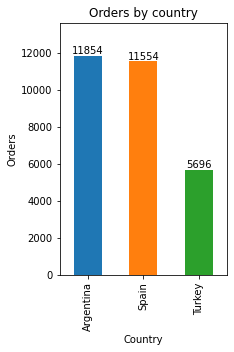

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the train set
df = pd.read_csv('train.csv')

numb_countries = 3

# Convert country code to country name using data from https://datahub.io/core/country-list
country_code_table = pd.read_csv('country_code.csv')
country_code_dic = {row.Code: row.Name for _, row in country_code_table.iterrows()}

top_countries = df.country_code.value_counts()
top_countries.index = (country_code_dic[idx] for idx in top_countries.index)

plt.figure(figsize=(numb_countries, 4))
plt.title('Orders by country')
plt.ylabel('Orders')
plt.xlabel('Country')
plt.subplots_adjust(top=1)

ax = top_countries[:numb_countries].plot(kind='bar', color=plt.cm.tab10(range(numb_countries)))
ax.bar_label(ax.containers[0])
ax.set_ymargin(.15)

## 2. ¿Cuáles son las horas en las que se realizan más pedidos en España?

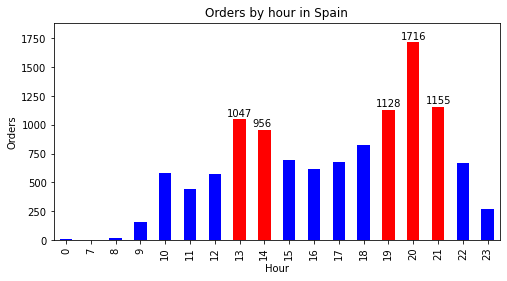

In [2]:
# Add local_hour row saving only the hour as an integer
df.insert(2, 'local_hour', df.local_time.str.slice(0, 2).astype('int'))

sp = df[df.country_code == 'ES'].copy()
sp_hour_orders = sp.local_hour.value_counts().sort_index()

numb_busy_hours = 5
sep_value = sorted(sp_hour_orders, reverse=True)[numb_busy_hours-1]

clrs = ['red' if x>=sep_value else 'blue' for x in sp_hour_orders]

plt.figure(figsize=(8, 4))
plt.title('Orders by hour in Spain')
plt.ylabel('Orders')
plt.xlabel('Hour')

ax = sp_hour_orders.plot(kind='bar', color=clrs)
ax.set_ymargin(.1)
for i, v in enumerate(sp_hour_orders):
    if v >= sep_value:
        ax.text(i-.5, v+30, str(v))

Hay dos picos de demanda, el más alto es a las 20h y dura 3h, mientras que el otro es a las 13h y dura 2h.

## 3. ¿Cuál es el precio medio por pedido en la tienda con ID 12513?

El precio medio por pedido en la tiena con ID 12513 es de 17.3922


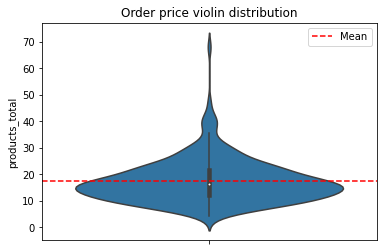

In [3]:
import seaborn as sns

store_id = 12513

store = df[ df.store_address == store_id ]
plt.title('Order price violin distribution')

mean = store.products_total.mean()

ax = sns.violinplot(y="products_total", data=store)
ax.axhline(mean, color='r', linestyle='--', label="Mean")
ax.legend()

print('El precio medio por pedido en la tiena con ID', store_id, 'es de', round(mean, 4))

## 4. ¿Qué porcentaje de repartidores pondrías por cada turno de 8h?

Teniendo en cuenta los picos de demanda en España, si los repartidores trabajan en turnos de 8 horas:

- Turno 1 (00:00-08:00)
- Turno 2 (08:00-16:00)
- Turno 3 (16:00-00:00)

¿Qué porcentaje de repartidores pondrías por cada turno para que sean capaces de hacer frente a los picos de demanda? (ej: Turno 1 el 30%, Turno 2 el 10% y Turno 3 el 60%).

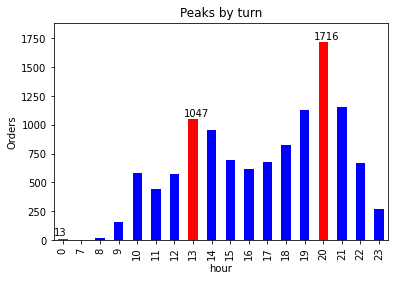

In [4]:
hours = pd.DataFrame(sp_hour_orders)
hours.index.name = 'hour'
hours.columns = ['orders']
hours['turn'] = hours.index//8 + 1

peak = hours.groupby('turn').max()
clrs = ['blue'] * hours.shape[0]
for i, idx_row in enumerate(hours.iterrows()):
    row = idx_row[1]
    if row.orders == peak.loc[row.turn].orders:
        clrs[i] = 'red'

plt.ylabel('Orders')
plt.title('Peaks by turn')

ax = hours.orders.plot(kind='bar', color=clrs)
ax.set_ymargin(.1)
for i, v in enumerate(sp_hour_orders):
    if clrs[i]=='red':
        ax.text(i-.5, v+30, str(v))

array([<AxesSubplot:ylabel='orders'>], dtype=object)

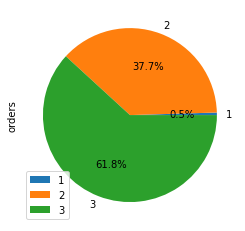

In [5]:
hours.groupby('turn').max().plot(kind='pie', autopct='%1.1f%%', subplots=True)

## 5. Modelo predictivo de machine learning para predecir si un pedido se cancelará o no

In [57]:
import pandas as pd

pd.read_csv('train.csv')

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus
...,...,...,...,...,...,...,...,...
54325,33443728,13:54:33,AR,63825,PAID,2,10.39,DeliveredStatus
54326,33499561,17:16:09,AR,27741,PAID,1,9.07,DeliveredStatus
54327,32895248,20:14:59,PA,65895,PAID,2,1.65,DeliveredStatus
54328,32792276,13:24:05,ES,20134,PAID,6,8.04,DeliveredStatus


In [126]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv')
data.local_time = pd.to_timedelta(data.local_time).dt.seconds / (60*60*24)
data.final_status = (data.final_status=='DeliveredStatus').astype('int')

relevant_categories = ['local_time', 'payment_status', 'n_of_products', 'products_total']

X = data[relevant_categories]
y = data.final_status

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [106]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold()
for s_X, s_y in skf.split(X_train, y_train):
    pass

In [97]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy=0.5)

X_train, y_train = oversample.fit_resample(X_train, y_train)

In [90]:
"""from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy=0.5)

X_train, y_train = undersample.fit_resample(X_train, y_train)"""

'from imblearn.under_sampling import RandomUnderSampler\n\nundersample = RandomUnderSampler(sampling_strategy=0.5)\n\nX_train, y_train = undersample.fit_resample(X_train, y_train)'

In [127]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = X.columns[X.dtypes=='object']

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)])

In [110]:
from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier

#model = RandomForestClassifier()

from xgboost import XGBClassifier

model = XGBClassifier()

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [115]:
my_pipeline.fit(X_train, y_train)

preds = my_pipeline.predict(X_valid)

C:\Users\Andreu Vall\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:30:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [116]:
(preds==0).sum()

110

In [117]:
from sklearn.metrics import f1_score

print(f1_score(y_valid, preds, average='macro'))
print(f1_score(y_valid, [1]*len(y_valid), average='macro'))

0.49156213058252635
0.4723819142324425


In [118]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_valid, preds)

array([[   31,  1391],
       [   79, 12082]], dtype=int64)

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv')
data.local_time = pd.to_timedelta(data.local_time).dt.seconds / (60*60)
data.final_status = (data.final_status=='DeliveredStatus').astype('int')


X = data[['local_time', 'country_code', 'payment_status', 'n_of_products', 'products_total']]
y = data.final_status

for col in X.columns[X.dtypes=='object']:
    X[col] = X[col].astype('category')

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [128]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = X.columns[X.dtypes=='object']

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)])

In [46]:
from sklearn.metrics import f1_score

f1_score(y_valid, preds, average='macro')

0.4739710978623364

In [134]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

xgb_params = {
    'n_estimators': [100, 500, 1000],     
    'max_depth': [3, 5, 10],     
    'min_samples_split': [2, 5, 10]
}

params = {
    'estimator': xgb,
    'param_grid': xgb_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}

clf = GridSearchCV(**params)

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', clf)
])

my_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['payment_status'], dtype='object'))])),
                ('model',
                 GridSearchCV(cv=5,
                              estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',...
                                                      num_parallel_tree=None,
                                                   

In [138]:
xgb = XGBClassifier(**clf.best_params_).fit(X_train, y_train)

def get_score(preds):
    return f1_score(y_valid, preds, average='macro')

get_score(my_pipeline.predict(X_valid))

C:\Users\Andreu Vall\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:payment_status